# 特征工程(Redeem)
根据之前数据探索的结果进行特征工程，包括特征的处理，新特征的构建

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font",family='YouYuan')

from sklearn.preprocessing import OneHotEncoder

In [2]:
user_profile = pd.read_csv('./Purchase Redemption Data/user_profile_table.csv')
user_balance_data = pd.read_csv('./Purchase Redemption Data/user_balance_table.csv')
mfd_day_share_interest = pd.read_csv('./Purchase Redemption Data/mfd_day_share_interest.csv')

时间转化成可读格式

In [3]:
# add tiemstamp to dataset
def add_timestamp(data, time_index='report_date'):
    data_balance = data.copy()
    data_balance['report_date'] = pd.to_datetime(data_balance[time_index], format= "%Y%m%d")
    data_balance['day'] = data_balance['report_date'].dt.day
    data_balance['month'] = data_balance['report_date'].dt.month
    data_balance['year'] = data_balance['report_date'].dt.year
    data_balance['week'] = data_balance['report_date'].dt.week
    data_balance['weekday'] = data_balance['report_date'].dt.weekday
    return data_balance.reset_index(drop=True)

In [4]:
# total amount
def get_total_balance(data, date='2014-03-31'):
    df_tmp = data.copy()
    df_tmp = df_tmp.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()
    df_tmp.reset_index(inplace=True)
    return df_tmp[(df_tmp['report_date']>= date)].reset_index(drop=True)

In [5]:
# test_data
def add_test_data(data, days=45):
    test_date = pd.DataFrame(columns=['total_purchase_amt','total_redeem_amt','report_date'])
    for i in range(1, days+1):
        t = data['report_date'].iloc[-1] + pd.Timedelta('%s days' % i)
        test_date.loc[i] = {'report_date': t}
    
    return pd.concat([data, test_date])

In [6]:
user_balance_data = add_timestamp(user_balance_data)
user_balance_data_sorted = get_total_balance(user_balance_data)
# 续上测试数据
user_balance_data_sorted = add_test_data(user_balance_data_sorted)
dataset = add_timestamp(user_balance_data_sorted)

<ipython-input-3-290f8283146f>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_balance['week'] = data_balance['report_date'].dt.week
<ipython-input-4-15c5c6fcabef>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tmp = df_tmp.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()


In [7]:
dataset

,report_date,total_purchase_amt,total_redeem_amt,day,month,year,week,weekday
0,2014-03-31,398884905,423852634,31,3,2014,14,0
1,2014-04-01,453320585,277429358,1,4,2014,14,1
2,2014-04-02,355347118,272612066,2,4,2014,14,2
3,2014-04-03,363877120,266605457,3,4,2014,14,3
4,2014-04-04,251895894,200192637,4,4,2014,14,4
...,...,...,...,...,...,...,...,...
194,2014-10-11,NaN,NaN,11,10,2014,41,5
195,2014-10-12,NaN,NaN,12,10,2014,41,6
196,2014-10-13,NaN,NaN,13,10,2014,42,0
197,2014-10-14,NaN,NaN,14,10,2014,42,1


## 稀疏特征构建（bool型）
### 根据时间特点构建特征
与week相关：
- 周几
- 是否周末

In [8]:
# 构建特征：is_weekend
dataset['is_weekend'] = dataset['weekday'].apply(lambda x: 1 if (x == 5) or (x == 6) else 0)

与month相关：
- 是否是当月第一天
- 是否是当月第二天
- 是否是上旬
- 是否是中旬
- 是否是下旬
- 是否是本月第一周
- 是否是本月第二周
- 是否是本月第三周
- 是否是本月第四周

In [9]:
# 构建特征：is_firstday_of_month
dataset['is_firstday_of_month'] = dataset['report_date'].apply(lambda x: 1 if x.day == 1 else 0)
# 构建特征：is_secondday_of_month
dataset['is_secondday_of_month'] = dataset['report_date'].apply(lambda x: 1 if x.day == 2 else 0)
# 构建特征；is_premonth
dataset['is_premonth'] = dataset['report_date'].apply(lambda x: 1 if (x.day >= 1) & (x.day < 10) else 0)
# 构建特征；is_midmonth
dataset['is_midmonth'] = dataset['report_date'].apply(lambda x: 1 if (x.day >= 10) & (x.day < 20) else 0)
# 构建特征；is_tailmonth
dataset['is_tailmonth'] = dataset['report_date'].apply(lambda x: 1 if (x.day >= 20) & (x.day <= 31) else 0)
# 构建特征：is_first_week
dataset['is_first_week'] = dataset['week'].apply(lambda x: 1 if x % 4 == 1 else 0)
# 构建特征：is_second_week
dataset['is_second_week'] = dataset['week'].apply(lambda x: 1 if x % 4 == 2 else 0)
# 构建特征：is_third_week
dataset['is_third_week'] = dataset['week'].apply(lambda x: 1 if x % 4 == 3 else 0)
# 构建特征：is_fourth_week
dataset['is_fourth_week'] = dataset['week'].apply(lambda x: 1 if x % 4 == 0 else 0)

与工作日相关（主要考虑到假期调休）：
- 是否是假期
- 是否明天是工作日
- 是否昨天是工作日
- 是否是周天并且工作
- 是否是节假日第一天
- 是否是节假日最后一天
- 是否是节假日后的上班第一天
- 是否是放假前一天
- 是否上班

2014-04-01到2014-09-30期间法定假期：  
1. 清明节（2014-04-05, 2014-04-06, 2014-04-07）
2. 劳动节（2014-05-01, 2014-05-02, 2014-05-03）
3. 端午节（2014-05-31, 2014-06-01, 2014-06-02）
4. 中秋节（2014-09-06, 2014-09-07, 2014-09-08）
5. 国庆节（2014-10-01, 2014-10-02, 2014-10-03, 2014-10-04, 2014-10-05, 2014-10-06, 2014-10-07）

In [10]:
# 构建特征：is_holiday
holiday_list = ['2014-04-05','2014-04-06','2014-04-07','2014-05-01','2014-05-02','2014-05-03',
                '2014-05-31','2014-06-01','2014-06-02','2014-09-06','2014-09-07','2014-09-08',
                '2014-10-01','2014-10-02','2014-10-03','2014-10-04','2014-10-05','2014-10-06',
                '2014-10-07',]
tmp_list = [pd.to_datetime(i) for i in holiday_list]
dataset['is_holiday'] = dataset['report_date'].apply(lambda x: 1 if x in tmp_list else 0)

In [11]:
# 构建特征：restday
dataset.eval('restday = is_holiday | is_weekend', inplace=True)
dataset.loc[dataset['report_date'].isin(['2014-09-28']), 'restday'] = 0
# 构建特征：is_work_tomorrow
dataset['is_work_tomorrow'] = ((dataset['restday'].shift(-1).fillna(1).astype('int')) ^ dataset['restday']) & dataset['restday']
# 构建特征：was_worked_yesterday
dataset['was_worked_yesterday'] = ((dataset['restday'].shift(1).fillna(0).astype('int')) ^ dataset['restday']) & dataset['restday']
# 构建特征：is_working_on_sunday
dataset['is_working_on_sunday'] = dataset.apply(lambda x: 1 if (x['weekday']==6) & (x['restday']==0) else 0, axis=1)
# 构建特征：is_firstday_of_holiday
dataset['is_firstday_of_holiday'] = ((dataset['is_holiday'].shift(1).fillna(0).astype('int')) ^ dataset['is_holiday']) & dataset['is_holiday']
# 构建特征：is_lastday_of_holiday
dataset['is_lastday_of_holiday'] = ((dataset['is_holiday'].shift(-1).fillna(0).astype('int')) ^ dataset['is_holiday']) & dataset['is_holiday']

In [12]:
# 构建特征：is_work
dataset['is_work'] = dataset['restday'].apply(lambda x: 1 if x==0 else 0)
# 构建特征：is_firstday_of_work
dataset['is_firstday_of_work'] = ((dataset['is_work'].shift(1).fillna(0).astype('int')) ^ dataset['is_work']) & dataset['is_work']
# 构建特征：is_lastday_of_workday
dataset['is_lastday_of_work'] = ((dataset['is_work'].shift(-1).fillna(1).astype('int')) ^ dataset['is_work']) & dataset['is_work']

In [13]:
# 对星期几进行编码
def encode_data(data, feature_name='weekday', encoder=OneHotEncoder()):
    total_balance = data.copy()
    week_feature = encoder.fit_transform(np.array(total_balance[feature_name]).reshape(-1, 1)).toarray()
    week_feature = pd.DataFrame(week_feature,columns= [feature_name + '_onehot_'+ str(x) for x in range(len(week_feature[0]))])
    #featureWeekday = pd.concat([total_balance, week_feature], axis = 1).drop(feature_name, axis=1)
    featureWeekday = pd.concat([total_balance, week_feature], axis = 1)
    return featureWeekday

In [14]:
# 独热编码星期几
dataset = encode_data(dataset)

In [15]:
dataset.drop(['restday'], axis=1, inplace=True)
dataset['total_purchase_amt'] = dataset['total_purchase_amt'].astype('float64')
dataset['total_redeem_amt'] = dataset['total_redeem_amt'].astype('float64')

### 筛选稀疏特征
#### 分布分析

In [16]:
# 最终的回归label集合和时间索引集合
labels = ['total_purchase_amt','total_redeem_amt']
date_indexs = ['week','year','month','weekday','day']

In [17]:
# 生成is特征集合
feature = dataset[[x for x in dataset.columns if x not in date_indexs]]

In [18]:
# 绘制箱型图
def draw_boxplot(data: pd.DataFrame)->None:
    f, axes = plt.subplots(7, 4, figsize=(18, 24))
    global date_indexs, labels
    count = 0
    for i in [x for x in data.columns if x not in date_indexs + labels + ['report_date']]:
        sns.boxenplot(x=i, y='total_redeem_amt', data=data, ax=axes[count // 4][count % 4])
        count += 1

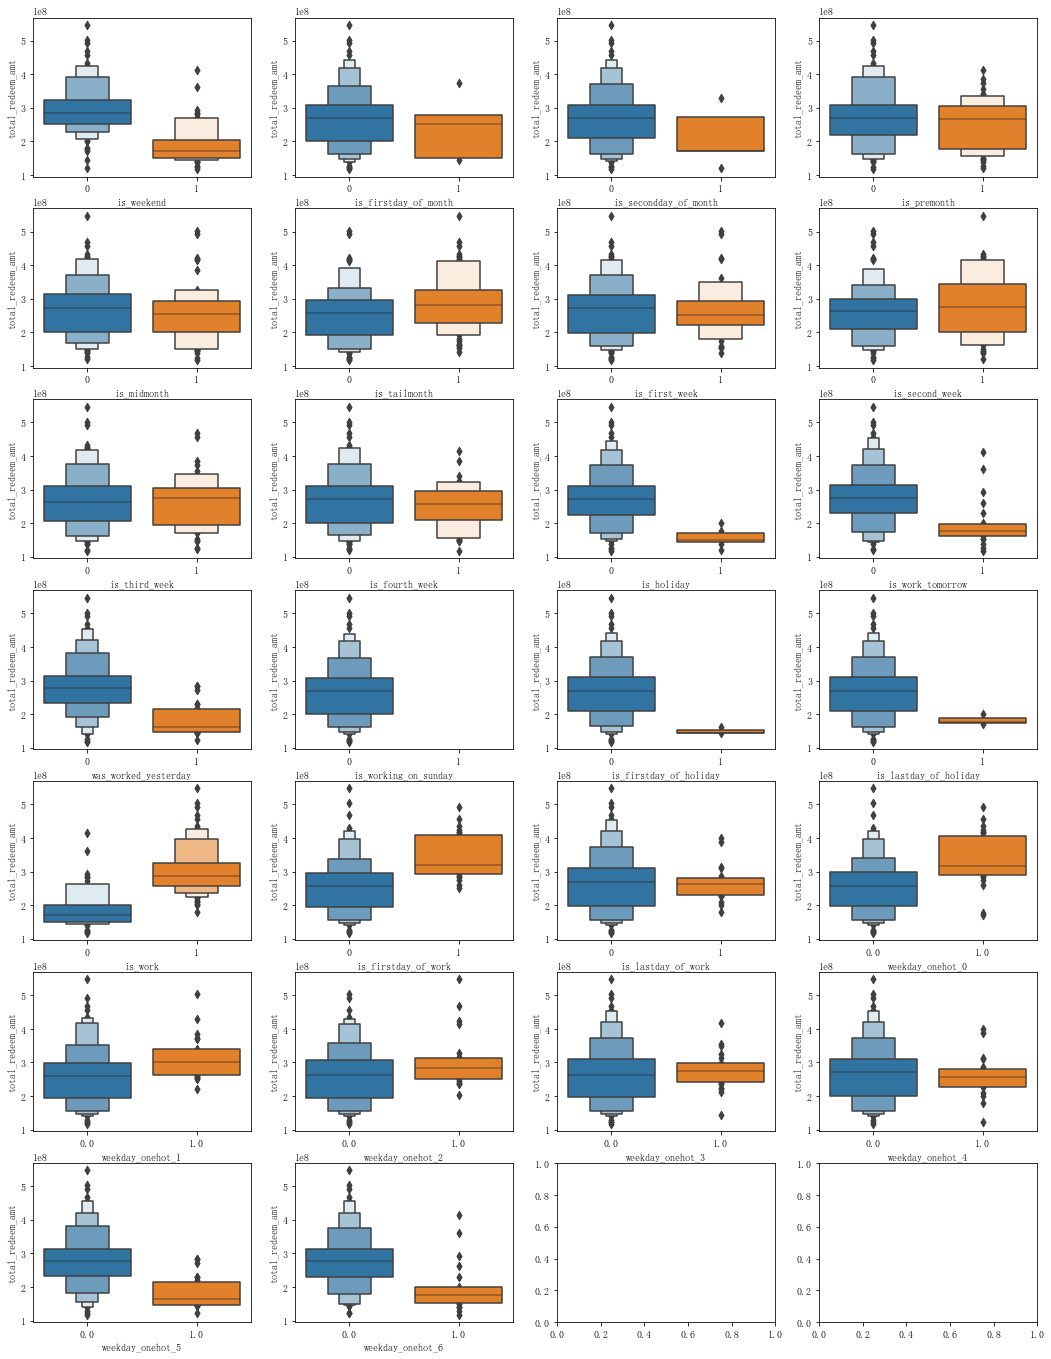

In [19]:
draw_boxplot(feature)

In [20]:
# 剔除看起来较差的特征
redeem_feature_seems_useless = [
      #样本量太少，建模时无效；但若确定这是一个有用规则，可以对结果做修正
      'is_working_on_sunday',
]

#### 相关性分析

In [21]:
# 画相关性热力图
def draw_correlation_heatmap(data, way='pearson'):
    feature = data.copy()
    plt.figure(figsize=(20,10))
    plt.title('The ' + way +' coleration between total purchase and each feature')
    sns.heatmap(feature[[x for x in feature.columns if x not in ['total_purchase_amt','report_date'] ]].corr(way),linecolor='white',
        linewidths=0.1,
        cmap="RdBu")

C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


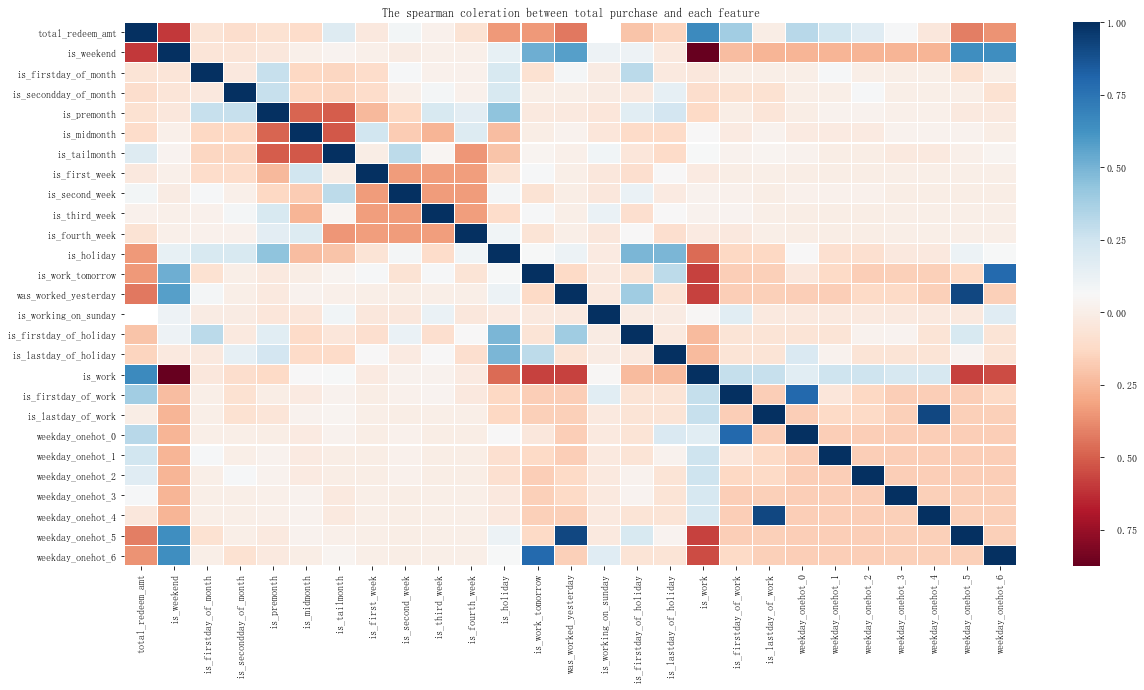

In [22]:
draw_correlation_heatmap(feature, 'spearman')

In [23]:
# 剔除相关性较低的特征
temp = np.abs(feature[[x for x in feature.columns 
                       if x not in ['total_purchase_amt', 'report_date'] ]].corr('spearman')['total_redeem_amt'])
feature_low_correlation = list(set(temp[temp < 0.1].index))

In [25]:
feature_low_correlation

['weekday_onehot_3',
 'is_firstday_of_month',
 'is_third_week',
 'is_second_week',
 'is_first_week',
 'is_premonth',
 'is_fourth_week',
 'is_lastday_of_work',
 'weekday_onehot_4']

In [26]:
feature[[x for x in feature.columns if x not in feature_low_correlation]].to_csv('Feature/redeem_bool_feature_0122.csv', index=False)

## 距离类型特征（数值型）
### 提取距离特征
- 距离房价还有多少天
- 距离上班还有多少天
- 距离节假日还有多少天
- 距离节假日最后一天还有多少天
- 距离月初的天数
- 距离月中的天数
- 距离周中的天数
- 距离周天的天数

In [26]:
# 提取距离特征
def extract_distance_feature(data: pd.DataFrame)->pd.DataFrame:
    total_balance = data.copy()
    
    # 距离放假还有多少天
    total_balance['dis_to_nowork'] = 0
    for index, row in total_balance.iterrows():
        if row['is_work'] == 0:
            step = 1
            flag = 1
            while flag:
                if index - step >= 0 and total_balance.loc[index - step, 'is_work'] == 1:
                    total_balance.loc[index - step, 'dis_to_nowork'] = step
                    step += 1
                else:
                    flag = 0

    total_balance['dis_from_nowork'] = 0
    step = 0
    for index, row in total_balance.iterrows():
        step += 1
        if row['is_work'] == 1:
            total_balance.loc[index, 'dis_from_nowork'] = step
        else:
            step = 0

    # 距离上班还有多少天
    total_balance['dis_to_work'] = 0
    for index, row in total_balance.iterrows():
        if row['is_work'] == 1:
            step = 1
            flag = 1
            while flag:
                if index - step >= 0 and total_balance.loc[index - step, 'is_work'] == 0:
                    total_balance.loc[index - step, 'dis_to_work'] = step
                    step += 1
                else:
                    flag = 0

    total_balance['dis_from_work'] = 0
    step = 0
    for index, row in total_balance.iterrows():
        step += 1
        if row['is_work'] == 0:
            total_balance.loc[index, 'dis_from_work'] = step
        else:
            step = 0


    # 距离节假日还有多少天
    total_balance['dis_to_holiday'] = 0
    for index, row in total_balance.iterrows():
        if row['is_holiday'] == 1:
            step = 1
            flag = 1
            while flag:
                if index - step >= 0 and total_balance.loc[index - step, 'is_holiday'] == 0:
                    total_balance.loc[index - step, 'dis_to_holiday'] = step
                    step += 1
                else:
                    flag = 0

    total_balance['dis_from_holiday'] = 0
    step = 0
    for index, row in total_balance.iterrows():
        step += 1
        if row['is_holiday'] == 0:
            total_balance.loc[index, 'dis_from_holiday'] = step
        else:
            step = 0

    # 距离节假日最后一天还有多少天
    total_balance['dis_to_holiendday'] = 0
    for index, row in total_balance.iterrows():
        if row['is_lastday_of_holiday'] == 1:
            step = 1
            flag = 1
            while flag:
                if index - step >= 0 and total_balance.loc[index - step, 'is_lastday_of_holiday'] == 0:
                    total_balance.loc[index - step, 'dis_to_holiendday'] = step
                    step += 1
                else:
                    flag = 0

    total_balance['dis_from_holiendday'] = 0
    step = 0
    for index, row in total_balance.iterrows():
        step += 1
        if row['is_lastday_of_holiday'] == 0:
            total_balance.loc[index, 'dis_from_holiendday'] = step
        else:
            step = 0

    # 距离月初第几天
    total_balance['dis_from_startofmonth'] = np.abs(total_balance['day'])

    # 距离月的中心点有几天
    total_balance['dis_from_middleofmonth'] = np.abs(total_balance['day'] - 15)

    # 距离星期的中心有几天
    total_balance['dis_from_middleofweek'] = np.abs(total_balance['weekday'] - 3)

    # 距离星期日有几天
    total_balance['dis_from_endofweek'] = np.abs(total_balance['weekday'] - 6)

    return total_balance

In [27]:
# 拼接距离特征到原数据集
dataset = extract_distance_feature(dataset)

### 距离特征分析

In [28]:
# 获取距离特征的列名
feature = dataset[[x for x in dataset.columns if x not in date_indexs]]
dis_feature_indexs = [x for x in feature.columns if (x not in date_indexs + labels + ['report_date']) & ('dis' in x)]

In [29]:
# 处理距离过远的时间点
def dis_change(x):
    if x > 5:
        x = 10
    return x

In [30]:
# 处理特殊距离
dis_holiday_feature = [x for x in dataset.columns if 'dis' in x and 'holi' in x]
dis_month_feature = [x for x in dataset.columns if 'dis' in x and 'month' in x]
dataset[dis_holiday_feature] = dataset[dis_holiday_feature].applymap(dis_change)
dataset[dis_month_feature] = dataset[dis_month_feature].applymap(dis_change)

In [31]:
feature = dataset[[x for x in dataset.columns if x not in date_indexs]]

In [32]:
# 画点线
def draw_point_feature(data: pd.DataFrame)->None:
    feature = data.copy()
    f, axes = plt.subplots(data.shape[1] // 3, 3, figsize=(30, data.shape[1] // 3 * 4))
    count = 0
    for i in [x for x in feature.columns if (x not in date_indexs + labels + ['date'])]:
        sns.pointplot(x=i, y="total_redeem_amt",
                markers=["^", "o"], linestyles=["-", "--"],
                kind="point", data=feature, ax=axes[count // 3][count % 3] if data.shape[1] > 3 else axes[count])
        count += 1

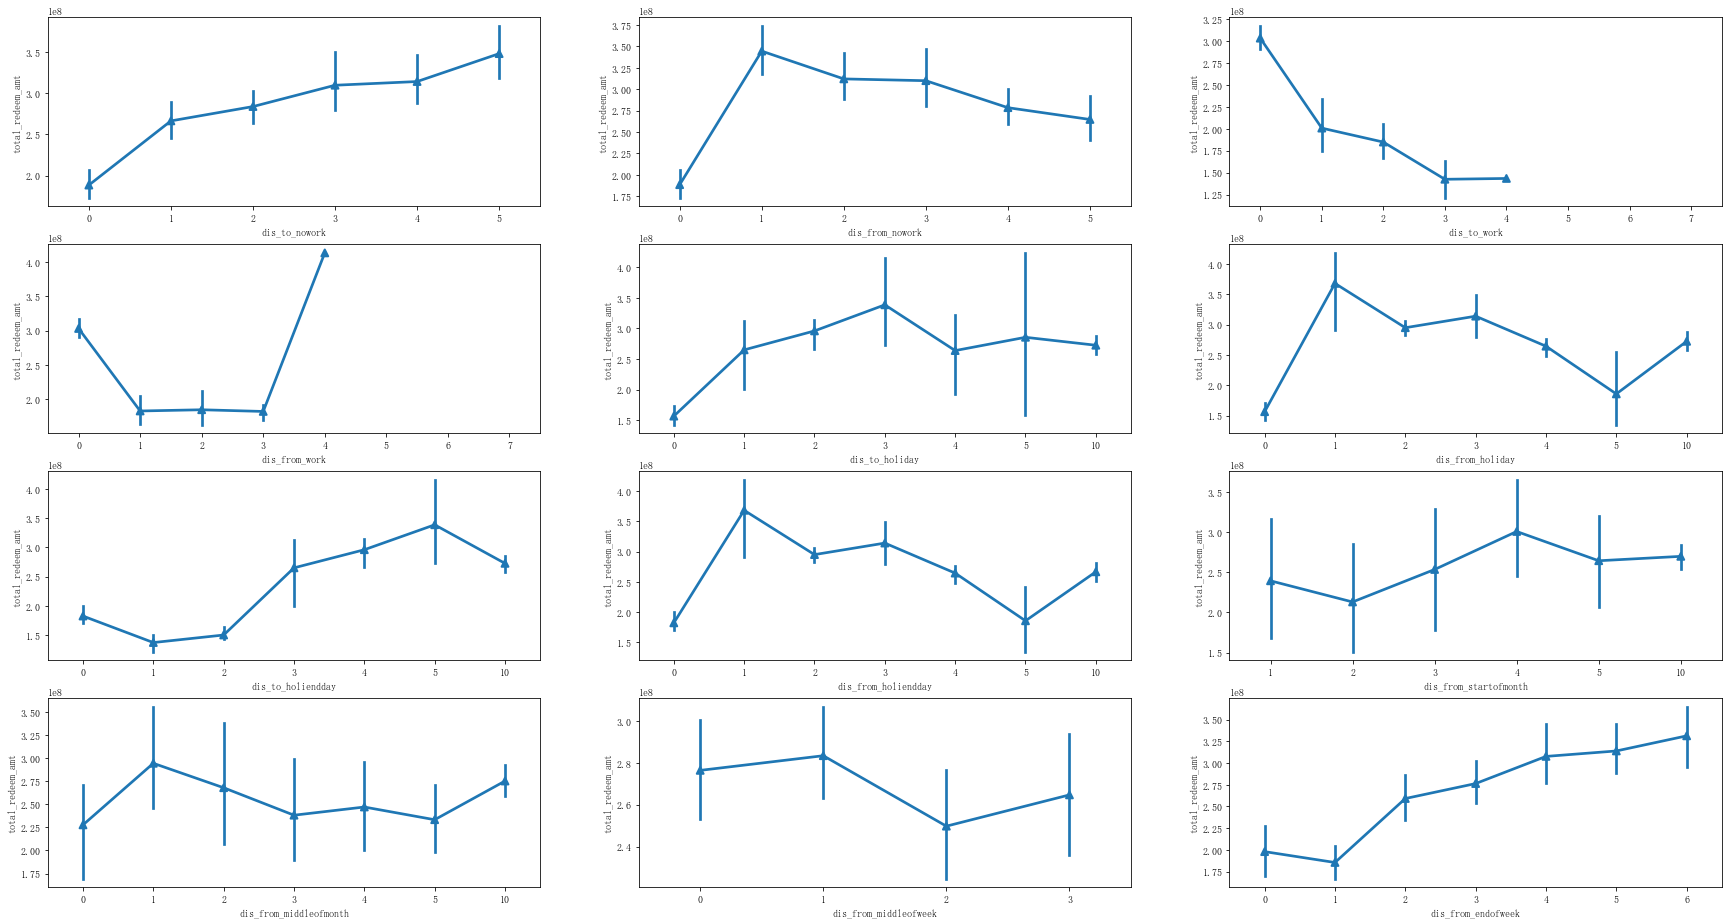

In [33]:
# 画处理后的点线图
draw_point_feature(feature[['total_redeem_amt'] + dis_feature_indexs])

In [34]:
# 剔除看起来用处不大的特征
redeem_feature_seems_useless += [
                                  #即使做了处理，但方差太大，不可信，规律不明显
                                  'dis_to_holiday',
                                  #方差太大，不可信
                                  'dis_from_startofmonth',
                                  #方差太大，不可信
                                  'dis_from_middleofmonth'
]

C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


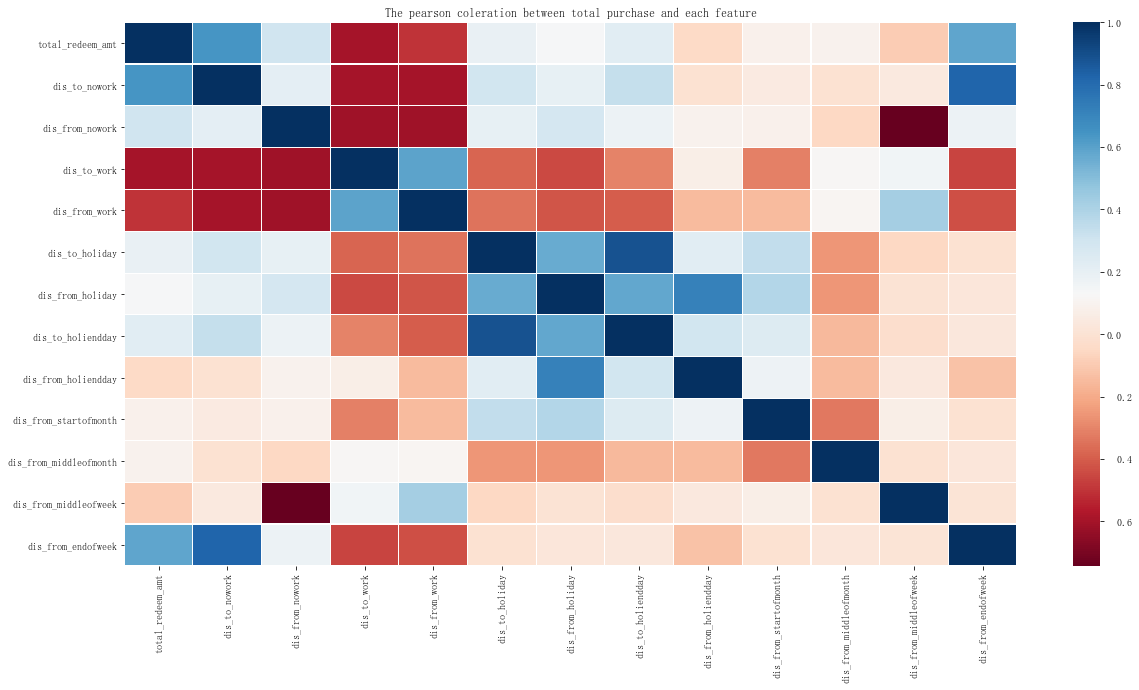

In [35]:
# 画出相关性图
draw_correlation_heatmap(feature[['total_redeem_amt'] + dis_feature_indexs])

In [39]:
# 剔除相关性较差的特征
temp = np.abs(feature[[x for x in feature.columns 
                       if ('dis' in x) | (x in ['total_redeem_amt']) ]].corr()['total_redeem_amt'])
feature_low_correlation += list(set(temp[temp < 0.1].index) )

In [41]:
feature_low_correlation

['weekday_onehot_3',
 'is_firstday_of_month',
 'is_third_week',
 'is_second_week',
 'is_first_week',
 'is_premonth',
 'is_fourth_week',
 'is_lastday_of_work',
 'weekday_onehot_4',
 'dis_from_startofmonth',
 'dis_from_holiday',
 'dis_from_middleofmonth',
 'dis_from_middleofweek',
 'dis_from_startofmonth',
 'dis_from_holiendday',
 'dis_from_middleofmonth']

## 波峰波谷特征
purchase
- purchase波峰时间记录
- purchase波谷时间记录

redeem
- redeem波峰时间记录
- redeem波谷时间记录


In [42]:
import datetime

### Redeem

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


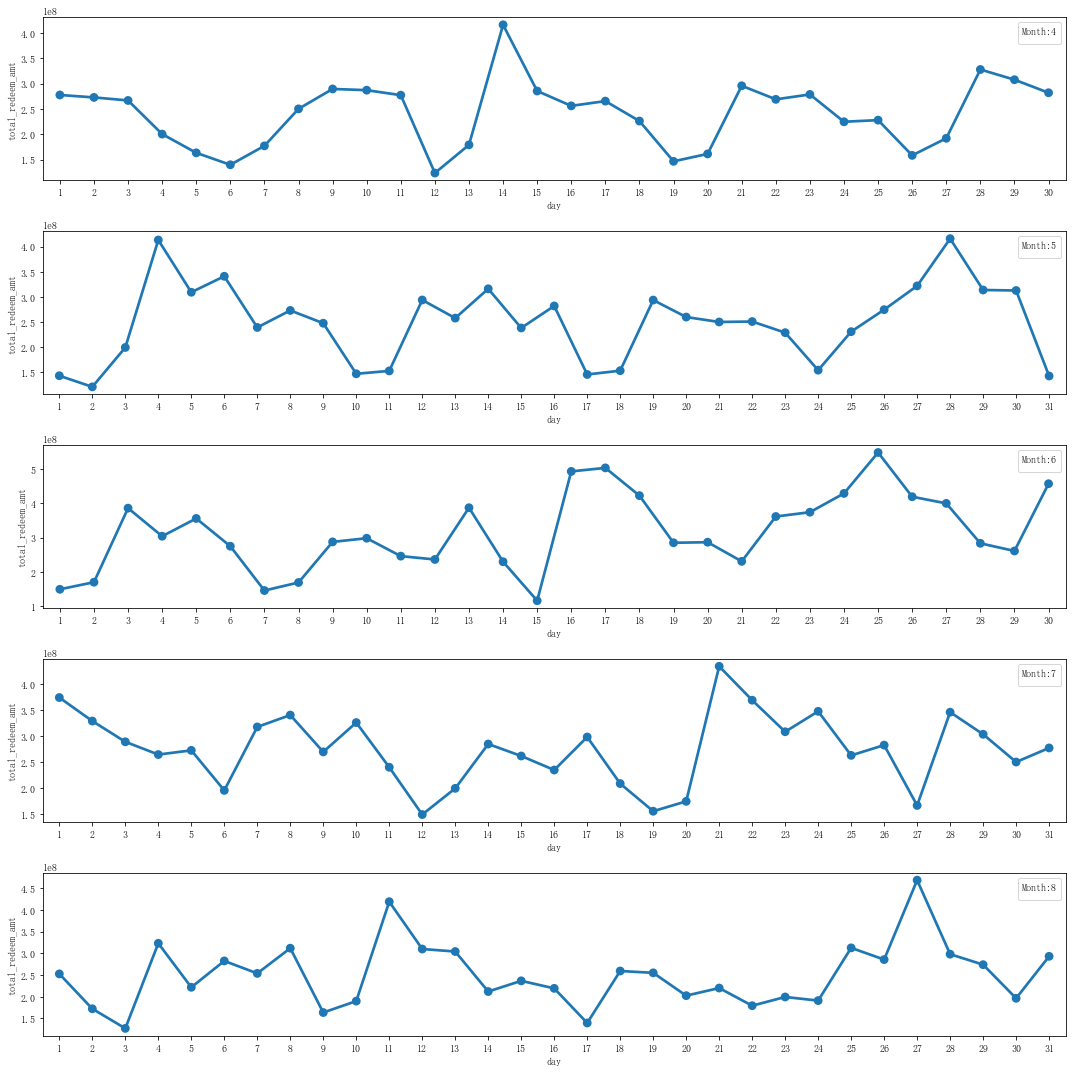

In [43]:
# 观察redeem波峰波谷特点
fig = plt.figure(figsize=(15,15))
for i in range(4, 9):
    plt.subplot(5, 1, i-3)
    dataset_2 = dataset[(dataset['report_date'] >= pd.to_datetime('2014-0%s-01' % i)) & 
                        (dataset['report_date'] < pd.to_datetime('2014-0%s-01' % (i+1)))]
    sns.pointplot(x=dataset_2['day'],y=dataset_2['total_redeem_amt'])
    plt.legend().set_title('Month:' + str(i))
plt.tight_layout()

In [44]:
# 按照统计redeem的波峰设定为周一，波谷设定为周六
# 设定波峰日期

def extract_peak_feature_r(data):
    total_balance = data.copy()
    # 距离purchase波峰（即周一）有几天
    total_balance['dis_from_redeem_peak'] = np.abs(total_balance['weekday'])

    # 距离purchase波谷（即周六）有几天
    total_balance['dis_from_redeem_valley'] = np.abs(total_balance['weekday'] - 5)
    
    return total_balance

In [45]:
# 提取波峰特征
dataset = extract_peak_feature_r(dataset)
feature = dataset[[x for x in dataset.columns if x not in date_indexs]]

In [46]:
# 画点线
def draw_point_feature_r(data: pd.DataFrame)->None:
    feature = data.copy()
    f, axes = plt.subplots(data.shape[1] // 3, 3, figsize=(30, data.shape[1] // 3 * 4))
    count = 0
    for i in [x for x in feature.columns if (x not in date_indexs + labels + ['date'])]:
        sns.pointplot(x=i, y="total_redeem_amt",
                markers=["^", "o"], linestyles=["-", "--"],
                kind="point", data=feature, ax=axes[count // 3][count % 3] if data.shape[1] > 3 else axes[count])
        count += 1

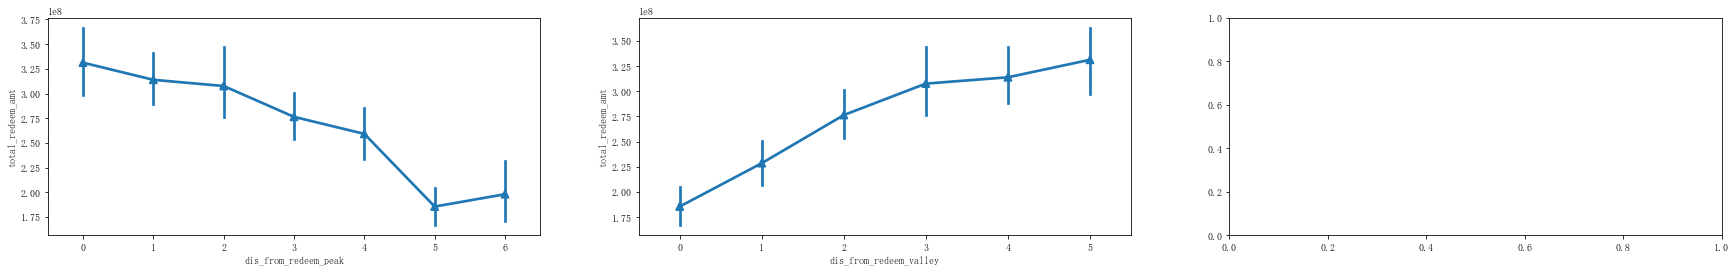

In [47]:
draw_point_feature_r(feature[['total_redeem_amt'] + ['dis_from_redeem_peak','dis_from_redeem_valley']])

In [48]:
temp = np.abs(feature[[x for x in feature.columns if ('peak' in x) or ('valley' in x) or (x in ['total_redeem_amt']) ]].corr()['total_redeem_amt'])

In [49]:
temp

total_redeem_amt          1.000000
dis_from_redeem_peak      0.588313
dis_from_redeem_valley    0.567252
Name: total_redeem_amt, dtype: float64

## 加入周期因子

In [50]:
def generate_rate(df, month_index):
    total_balance = df.copy()
    pure_balance = total_balance[['report_date','total_purchase_amt','total_redeem_amt']]
    pure_balance = pure_balance[(pure_balance['report_date'] >= datetime.datetime(2014,3,1)) & (pure_balance['report_date'] < datetime.datetime(2014, month_index, 1))]
    pure_balance['weekday'] = pure_balance['report_date'].dt.weekday
    pure_balance['day'] = pure_balance['report_date'].dt.day
    pure_balance['week'] = pure_balance['report_date'].dt.week
    pure_balance['month'] = pure_balance['report_date'].dt.month
    weekday_rate = pure_balance[['weekday']+labels].groupby('weekday',as_index=False).mean()
    for name in labels:
        weekday_rate = weekday_rate.rename(columns={name: name+'_weekdaymean'})
    weekday_rate['total_purchase_amt_weekdaymean'] /= np.mean(pure_balance['total_purchase_amt'])
    weekday_rate['total_redeem_amt_weekdaymean'] /= np.mean(pure_balance['total_redeem_amt'])
    pure_balance = pd.merge(pure_balance, weekday_rate, on='weekday', how='left')
    weekday_count = pure_balance[['day','weekday','report_date']].groupby(['day','weekday'],as_index=False).count()
    weekday_count = pd.merge(weekday_count, weekday_rate, on = 'weekday')
    weekday_count['total_purchase_amt_weekdaymean'] *= weekday_count['report_date'] / (len(set(pure_balance['month'])) - 1)
    weekday_count['total_redeem_amt_weekdaymean'] *= weekday_count['report_date'] / (len(set(pure_balance['month'])) - 1)
    day_rate = weekday_count.drop(['weekday','report_date'],axis=1).groupby('day',as_index=False).sum()
    weekday_rate.columns = ['weekday','purchase_weekdayrate','redeem_weekdayrate']
    day_rate.columns = ['day','purchase_dayrate','redeem_dayrate']
    day_rate['report_date'] = datetime.datetime(2014, month_index, 1)
    for index, row in day_rate.iterrows():
        if month_index in (2,4,6,9) and row['day'] == 31:
            continue
        day_rate.loc[index, 'report_date'] = datetime.datetime(2014, month_index, int(row['day']))
    day_rate['weekday'] = day_rate['report_date'].dt.weekday
    day_rate = pd.merge(day_rate, weekday_rate, on='weekday')
    day_rate['purchase_dayrate'] = day_rate['purchase_weekdayrate'] / day_rate['purchase_dayrate']
    day_rate['redeem_dayrate'] = day_rate['redeem_weekdayrate'] / day_rate['redeem_dayrate']
    weekday_rate['month'] = month_index
    day_rate['month'] = month_index
    
    return weekday_rate, day_rate[['day','purchase_dayrate','redeem_dayrate','month']].sort_values('day')

In [51]:
# 生成周期因子并合并到数据集

weekday_rate_list = []
day_rate_list = []
for i in range(3, 10):
    weekday_rate, day_rate = generate_rate(dataset, i)
    weekday_rate_list.append(weekday_rate.reset_index(drop=True))
    day_rate_list.append(day_rate.reset_index(drop=True))

weekday_rate_list = pd.concat(weekday_rate_list).reset_index(drop=True)
day_rate_list = pd.concat(day_rate_list).reset_index(drop=True)
dataset = pd.merge(dataset, weekday_rate_list, on=['weekday','month'], how='left')
dataset = pd.merge(dataset, day_rate_list, on=['day','month'], how='left')

<ipython-input-50-12aa908a42ec>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  pure_balance['week'] = pure_balance['report_date'].dt.week


In [52]:
# 对周期因子进行特殊处理

for i in [x for x in dataset.columns 
          if 'rate' in x and x not in labels + date_indexs]:
    dataset[i] = dataset[i].fillna(np.nanmedian(dataset[i]))

### 分析周期因子相关性

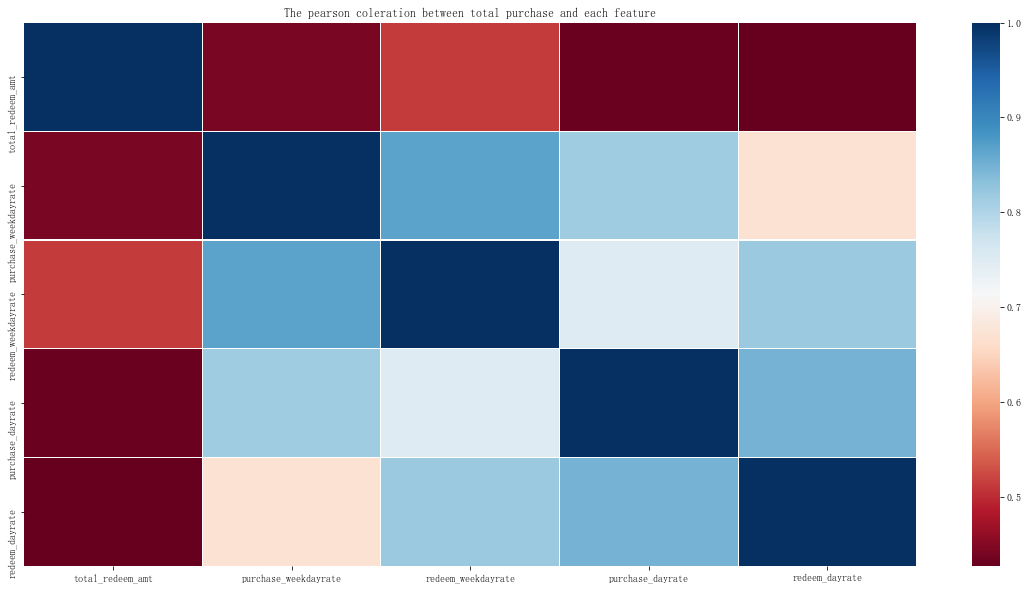

In [53]:
# 画出相关性图

draw_correlation_heatmap(dataset[['total_redeem_amt'] + [x for x in dataset.columns if 'rate' in x and x not in labels + date_indexs]])

In [54]:
# 剔除相关性低的特征

feature = dataset.drop(date_indexs, axis=1)

## 加入动态时序特征
### 提取动态时序特征
这部分是统计随时间变化的purhase和redeem的动态统计量

In [55]:
## 提取动态特征

def get_amtfeature_with_time(data):
    df_tmp_ = data[labels + date_indexs + ['report_date']].copy()
    total_balance = data.copy()
    
    df_tmp_ = df_tmp_[(df_tmp_['report_date']>=datetime.datetime(2014,3,3))]
    df_tmp_['weekday'] = df_tmp_['report_date'].dt.weekday + 1
    df_tmp_['week'] = df_tmp_['report_date'].dt.week - min(df_tmp_['report_date'].dt.week) + 1
    df_tmp_['day'] = df_tmp_['report_date'].dt.day
    df_tmp_['month'] = df_tmp_['report_date'].dt.month
    df_tmp_.reset_index(inplace=True)
    del df_tmp_['index']
    df_purchase = pd.DataFrame(columns = ['weekday1','weekday2','weekday3','weekday4',
                                          'weekday5','weekday6','weekday7'])
    count = 0

    for i in range(len(df_tmp_)):
        df_purchase.loc[count,'weekday'+str(df_tmp_.loc[i,'weekday'])] = df_tmp_.loc[i,'total_redeem_amt']
        if df_tmp_.loc[i,'weekday'] == 7:
            count = count + 1

    df_tmp_['redeem_weekday_median'] = np.nan
    df_tmp_['redeem_weekday_mean'] = np.nan
    df_tmp_['redeem_weekday_min'] = np.nan
    df_tmp_['redeem_weekday_max'] = np.nan
    df_tmp_['redeem_weekday_std'] = np.nan
    df_tmp_['redeem_weekday_skew'] = np.nan

    for i in range(len(df_tmp_)):
        #从2014年3月31日开始统计
        if i > 4*7-1:
            df_tmp_.loc[i,'redeem_weekday_median'] = df_purchase.loc[:df_tmp_.loc[i,'week']-2,
                                          'weekday'+str(df_tmp_.loc[i,'weekday'])].median()

            df_tmp_.loc[i,'redeem_weekday_mean'] = df_purchase.loc[:df_tmp_.loc[i,'week']-2,
                                          'weekday'+str(df_tmp_.loc[i,'weekday'])].mean()

            df_tmp_.loc[i,'redeem_weekday_min'] = df_purchase.loc[:df_tmp_.loc[i,'week']-2,
                                          'weekday'+str(df_tmp_.loc[i,'weekday'])].min()    

            df_tmp_.loc[i,'redeem_weekday_max'] = df_purchase.loc[:df_tmp_.loc[i,'week']-2,
                                          'weekday'+str(df_tmp_.loc[i,'weekday'])].max()   

            df_tmp_.loc[i,'redeem_weekday_std'] = df_purchase.loc[:df_tmp_.loc[i,'week']-2,
                                          'weekday'+str(df_tmp_.loc[i,'weekday'])].std() 

            df_tmp_.loc[i,'redeem_weekday_skew'] = df_purchase.loc[:df_tmp_.loc[i,'week']-2,
                                          'weekday'+str(df_tmp_.loc[i,'weekday'])].skew() 

    colList = ['redeem_weekday_median','redeem_weekday_mean','redeem_weekday_min',
               'redeem_weekday_max','redeem_weekday_std','redeem_weekday_skew']
    total_balance = pd.merge(total_balance, df_tmp_[colList+['day','month']], on=['day','month'], how='left')
    return total_balance

In [56]:
# 合并特征到数据集
dataset = get_amtfeature_with_time(dataset)

<ipython-input-55-a2922bd135f9>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_tmp_['week'] = df_tmp_['report_date'].dt.week - min(df_tmp_['report_date'].dt.week) + 1


In [57]:
# 对动态特征做特殊处理
for i in [x for x in dataset.columns if '_weekday_' in x and x not in labels + date_indexs]:
    dataset[i] = dataset[i].fillna(np.nanmedian(dataset[i]))

### 分析动态特征的相关性

C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


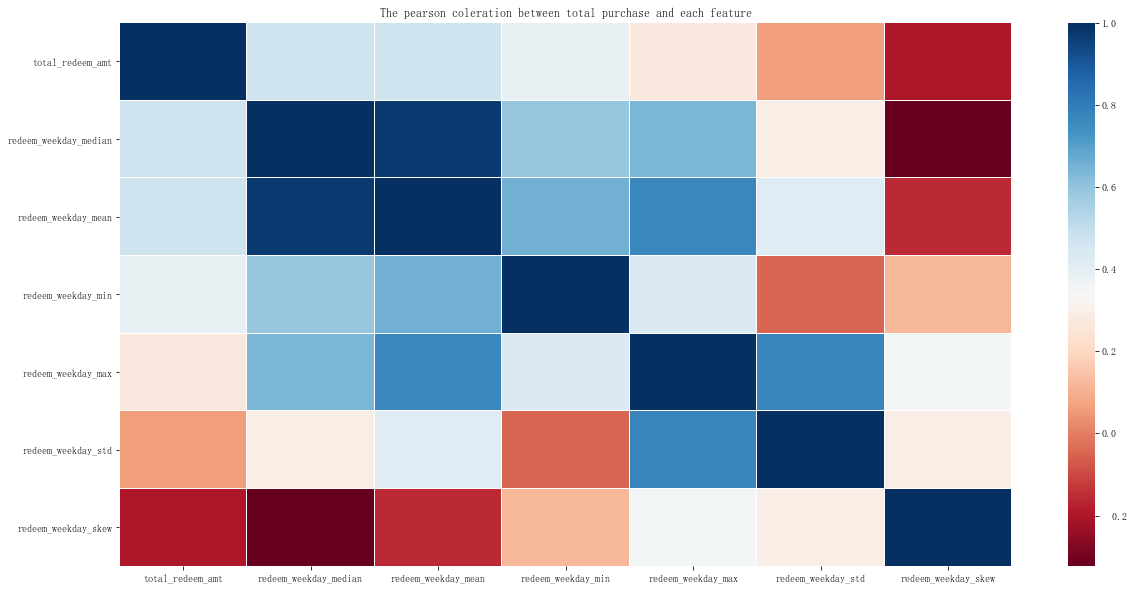

In [58]:
# 绘制动态特征的相关性图

draw_correlation_heatmap(dataset[['total_redeem_amt'] + 
                                ['redeem_weekday_median',
                                'redeem_weekday_mean','redeem_weekday_min',
                                'redeem_weekday_max','redeem_weekday_std',
                                'redeem_weekday_skew'
                                ]])

In [59]:
dataset[['total_redeem_amt'] + 
                                ['redeem_weekday_median',
                                'redeem_weekday_mean','redeem_weekday_min',
                                'redeem_weekday_max','redeem_weekday_std',
                                'redeem_weekday_skew'
                                ]].corr()['total_redeem_amt']

total_redeem_amt         1.000000
redeem_weekday_median    0.476886
redeem_weekday_mean      0.474598
redeem_weekday_min       0.386059
redeem_weekday_max       0.267169
redeem_weekday_std       0.062082
redeem_weekday_skew     -0.197402
Name: total_redeem_amt, dtype: float64

In [60]:
# 把相关性小于0.1的特征加入到待选
feature_low_correlation += ['redeem_weekday_std']

In [57]:
feature[['dis_to_nowork', 'dis_to_work', 'dis_from_work', 'redeem_weekdayrate',
       'redeem_dayrate', 'weekday_onehot_5', 'weekday_onehot_6',
       'dis_from_nowork', 'is_holiday', 'weekday_onehot_1', 'weekday_onehot_2',
       'weekday_onehot_0', 'dis_from_middleofweek', 'dis_from_holiendday',
       'weekday_onehot_3', 'is_lastday_of_holiday', 'is_firstday_of_holiday',
       'weekday_onehot_4', 'was_worked_yesterday', 'is_second_week',
       'is_third_week', 'dis_from_startofmonth', 'dis_from_holiday', 'total_purchase_amt',
       'total_redeem_amt', 'report_date']].to_csv('Feature/0122_residual_redeem_origined.csv', index=False)

## 特征筛选
### 用kde剔除分布相似的特征

In [61]:
feature.head()

,report_date,total_purchase_amt,total_redeem_amt,is_weekend,is_firstday_of_month,is_secondday_of_month,is_premonth,is_midmonth,is_tailmonth,is_first_week,...,dis_from_startofmonth,dis_from_middleofmonth,dis_from_middleofweek,dis_from_endofweek,dis_from_redeem_peak,dis_from_redeem_valley,purchase_weekdayrate,redeem_weekdayrate,purchase_dayrate,redeem_dayrate
0,2014-03-31,398884905.0,423852634.0,0,0,0,0,0,1,0,...,10,10,3,6,0,5,1.125999,1.014235,1.114807,1.013956
1,2014-04-01,453320585.0,277429358.0,0,1,0,1,0,0,0,...,1,10,2,5,1,4,1.125999,1.014235,1.114807,1.013956
2,2014-04-02,355347118.0,272612066.0,0,0,1,1,0,0,0,...,2,10,1,4,2,3,1.125999,1.014235,1.114807,1.013956
3,2014-04-03,363877120.0,266605457.0,0,0,0,1,0,0,0,...,3,10,0,3,3,2,1.125999,1.014235,1.114807,1.013956
4,2014-04-04,251895894.0,200192637.0,0,0,0,1,0,0,0,...,4,10,1,2,4,1,1.125999,1.014235,1.114807,1.013956


<ipython-input-62-a3b21a6dfa03>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(feature.columns) / 4, 4, count)
<ipython-input-62-a3b21a6dfa03>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(feature.columns) / 4, 4, count)
<ipython-input-62-a3b21a6dfa03>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(feature.columns) / 4, 4, count)
<ipython-input-62-a3b21a6dfa03>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(feature.columns) / 4, 4, count)
<ipython-inp

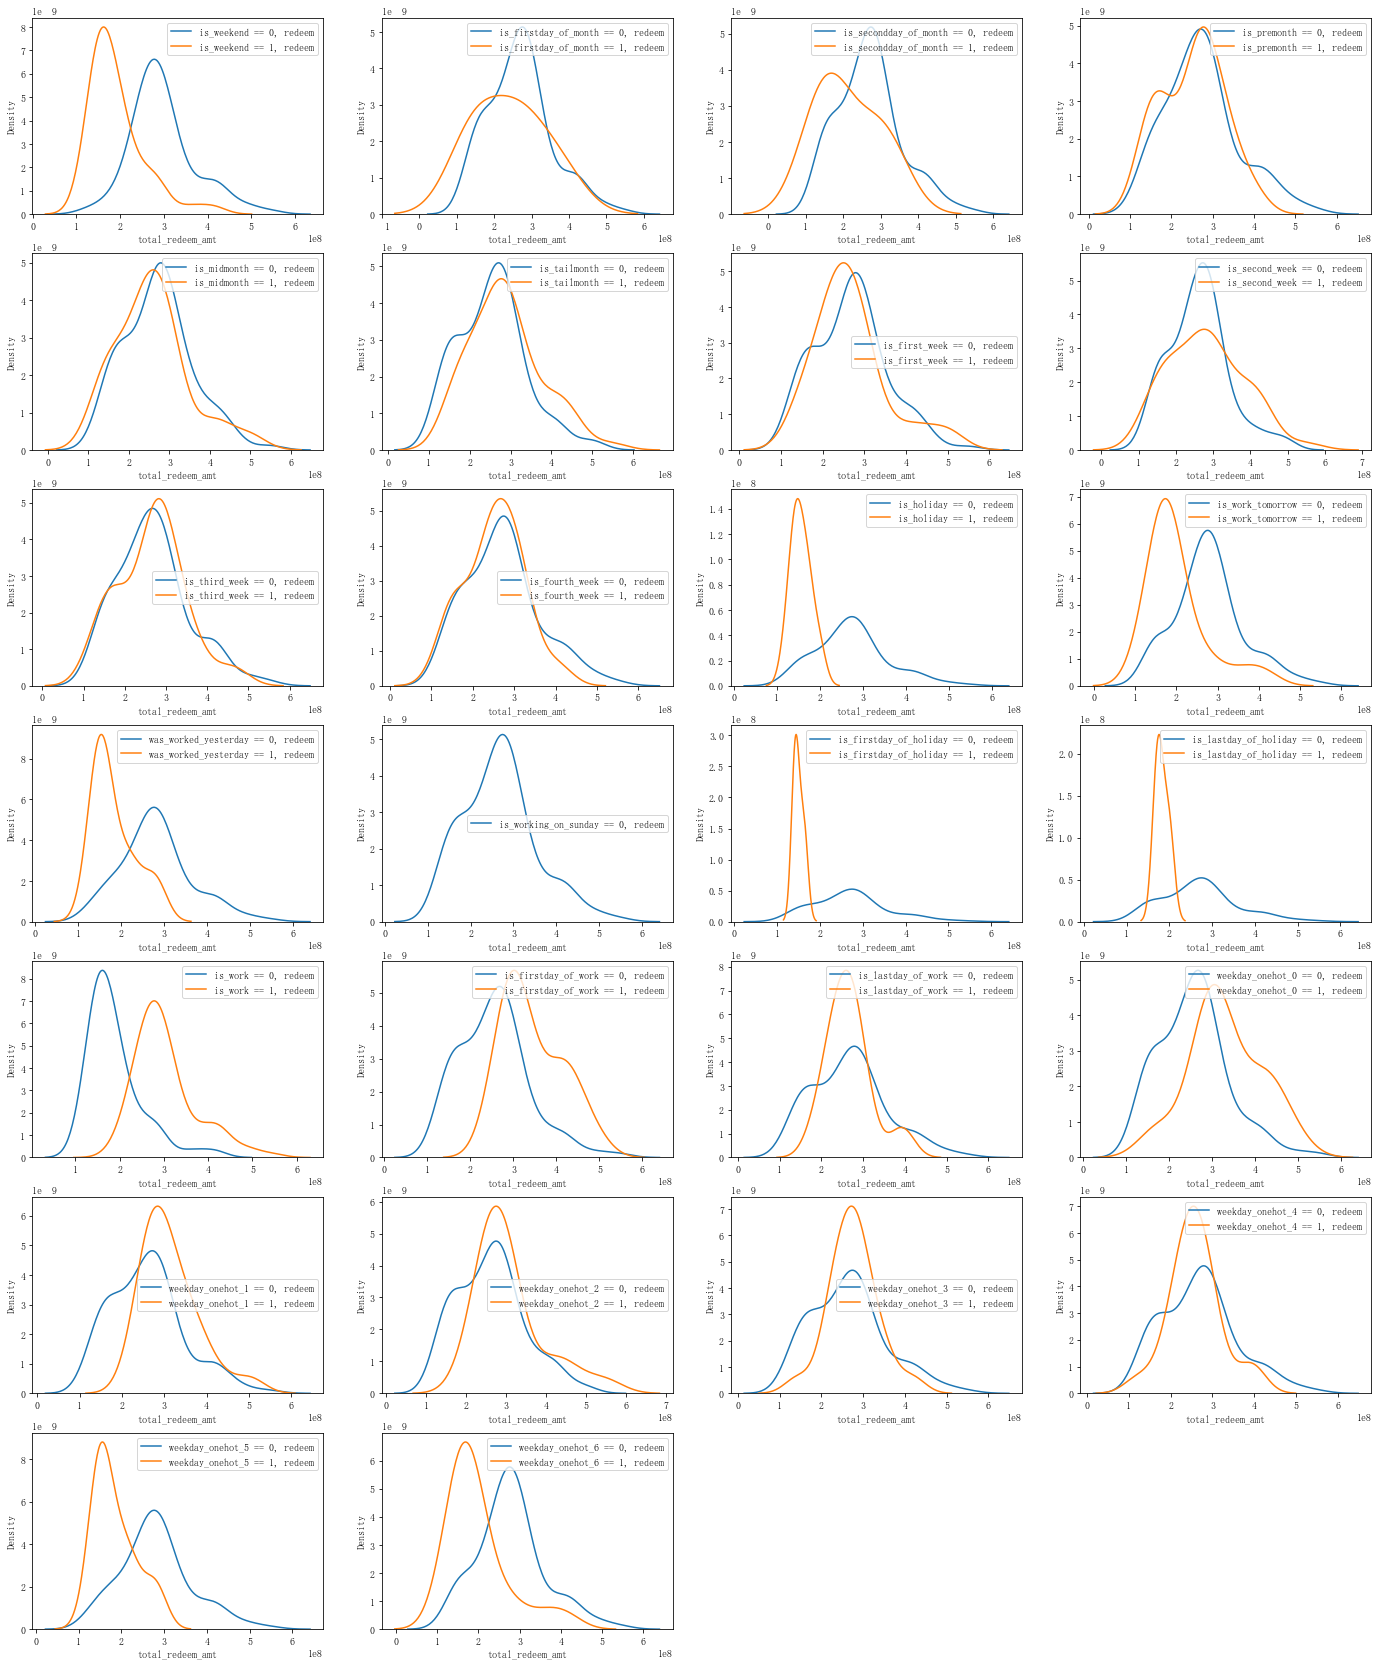

In [62]:
# 画出各个特征分割数据集的分布估计图
plt.figure(figsize=(4 * 6, 6 * len(feature.columns) / 6))
count = 0
for i in [x for x in feature.columns 
          if (x not in labels + date_indexs + ['report_date']) 
          & ('amt' not in x) & ('dis' not in x) & ('rate' not in x)]:
    count += 1
    if feature[feature[i] == 0].empty:
        continue
    plt.subplot(len(feature.columns) / 4, 4, count)
    
    ax = sns.kdeplot(feature[feature[i] == 0]['total_redeem_amt'], label= str(i) + ' == 0, redeem')
    ax = sns.kdeplot(feature[feature[i] == 1]['total_redeem_amt'], label= str(i) + ' == 1, redeem') 
    plt.legend()

In [63]:
# 剔除对数据集划分不明显的特征

redeem_feature_seems_useless += ['is_premonth','is_midmonth','is_tailmonth','is_third_week','is_fourth_week','is_secondday_of_month']

### 用MVtest挽回有依赖性但是不相关的特征
MVtest检测独立性

In [64]:
from mvtpy import mvtest

In [65]:
feature_low_correlation

['weekday_onehot_3',
 'is_firstday_of_month',
 'is_third_week',
 'is_second_week',
 'is_first_week',
 'is_premonth',
 'is_fourth_week',
 'is_lastday_of_work',
 'weekday_onehot_4',
 'dis_from_startofmonth',
 'dis_from_holiday',
 'dis_from_middleofmonth',
 'dis_from_middleofweek',
 'dis_from_startofmonth',
 'dis_from_holiendday',
 'dis_from_middleofmonth',
 'redeem_weekday_std']

In [66]:
# MVtest Ref: https://github.com/ChuanyuXue/MVTest

l = mvtest.mvtest()

name_list = []
Tn_list = []
p_list = []
for i in [i for i in feature_low_correlation if 'is' in i or 'discret' in i]:
    pair = l.test(feature['total_redeem_amt'], feature[i])
    name_list.append(str(i))
    Tn_list.append(pair['Tn'])
    p_list.append(pair['p-value'][0])
temp = pd.DataFrame([name_list,Tn_list]).T.sort_values(1)
temp[1] = np.abs(temp[1])
feature_saved_from_mv_redeem = list(temp.sort_values(1, ascending=False)[temp[1] > 0.5984][0])

<ipython-input-66-16e86abe6c97>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  feature_saved_from_mv_redeem = list(temp.sort_values(1, ascending=False)[temp[1] > 0.5984][0])


In [67]:
feature_saved_from_mv_redeem

['dis_from_holiday', 'dis_from_holiendday']

### 筛掉复共线特征
有些特征之间复共线性很高，会影响回归精度

In [75]:
feature = feature[[x for x in feature.columns 
                   if (x not in feature_low_correlation + redeem_feature_seems_useless) or\
                   (x in feature_saved_from_mv_redeem )]]

In [ ]:
###### （有待商榷）将dataset中的动态特征也合并到feature中
feature = pd.merge(feature, dataset[['redeem_weekday_median',
                                     'redeem_weekday_mean','redeem_weekday_min',
                                     'redeem_weekday_max',
                                     'redeem_weekday_skew','report_date'
                                     ]], on='report_date')

In [76]:
redeem_cors = feature.corr()
redeem_cors['total_redeem_amt'] = np.abs(redeem_cors['total_redeem_amt'])
feature_lists = list(redeem_cors.sort_values(by='total_redeem_amt',ascending=False).index)[2:]
feature_temp = feature.dropna()

In [77]:
# 这里要注意 保留的时候按照相关性降序排序 剔除按照相关性升序排序的顺序
thershold = 0.8
for i in range(len(feature_lists)):
    for k in range(len(feature_lists)-1, -1, -1):
        if i >= len(feature_lists) or k >= len(feature_lists) or i == k:
            break
        if np.abs(np.corrcoef(feature_temp[feature_lists[i]], feature_temp[feature_lists[k]])[0][1]) > thershold:
            higher_feature_temp = feature_temp[feature_lists[i]] * feature_temp[feature_lists[k]]
            if np.abs(np.corrcoef(feature_temp[feature_lists[i]], higher_feature_temp)[0][1]) <= thershold:
                name = str(feature_lists[i]) + '%%%%' + str(feature_lists[k])
                feature_temp[name] = higher_feature_temp
                feature[name] = feature[feature_lists[i]] * feature[feature_lists[k]]
                feature_lists.append(name)
            feature_temp = feature_temp.drop(feature_lists[k], axis=1)
            feature_lists.remove(feature_lists[k])

In [78]:
feature = feature[[x for x in feature_lists if x not in labels] + labels + ['report_date']]

In [79]:
feature.to_csv('Feature/redeem_feature_droped_0123.csv',index=False)

## 多种方法选出最终特征

In [79]:
# 分割数据集
def split_data_underline(data):
    trainset = data[(datetime.datetime(2014,4,1) <= data['report_date']) & (data['report_date'] < datetime.datetime(2014,8,1))]
    testset = data[(datetime.datetime(2014,8,1) <= data['report_date']) & (data['report_date'] < datetime.datetime(2014,9,1))]
    return trainset, testset

### 用SHAP来获取优胜特征
SHAP包本是来作为模型解释的包，可用来观测各个特征对于模型的贡献值。  
下面用一个决策树模型来观测特征的importance，并筛选特征

In [80]:
from sklearn import tree
import shap

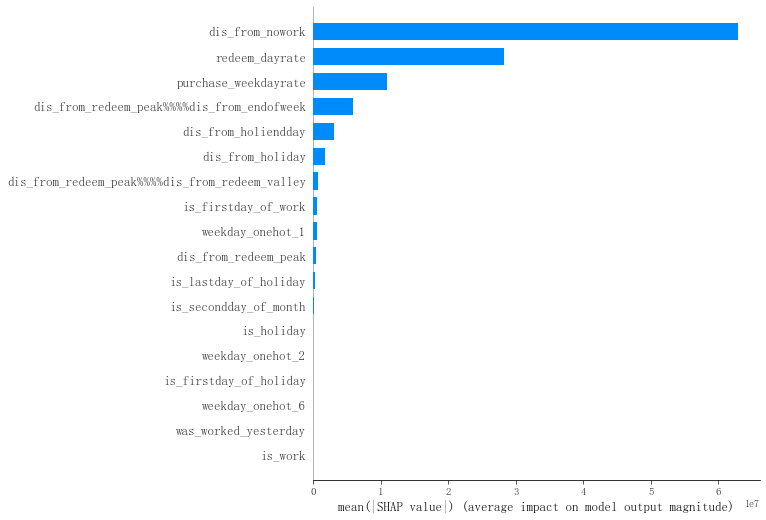

Glyph 8722 missing from current font.
Glyph 8722 missing from current font.


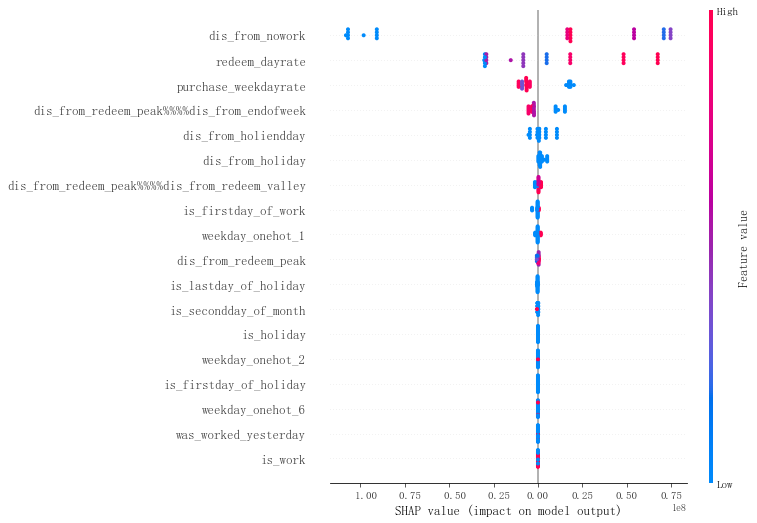

In [81]:
shap.initjs()

model = tree.DecisionTreeRegressor()
train, test = split_data_underline(feature.dropna())
features = [x for x in train.columns if x not in date_indexs]
model.fit(train[features].drop(labels+['report_date'], axis=1), train['total_redeem_amt'])

explainer = shap.TreeExplainer(model)
shap_testues = explainer.shap_values(test[features].drop(labels+['report_date'], axis=1))

shap.summary_plot(shap_testues, test[features].drop(labels+['report_date'], axis=1), plot_type='bar')

shap.summary_plot(shap_testues, test[features].drop(labels+['report_date'], axis=1))

tree_important_purchase = pd.DataFrame(np.mean(np.abs(shap_testues), axis=0),[x for x in features if x not in labels + date_indexs + ['report_date']]).reset_index()

In [82]:
# 选择降序前20个特征作为筛选后的特征
tree_important_purchase = tree_important_purchase.sort_values(0, ascending=False).reset_index(drop=True)
tree_important_purchase = list(tree_important_purchase[:20]['index'])

In [83]:
tree_important_purchase

['dis_from_nowork',
 'redeem_dayrate',
 'purchase_weekdayrate',
 'dis_from_redeem_peak%%%%dis_from_endofweek',
 'dis_from_holiendday',
 'dis_from_holiday',
 'dis_from_redeem_peak%%%%dis_from_redeem_valley',
 'is_firstday_of_work',
 'weekday_onehot_1',
 'dis_from_redeem_peak',
 'is_lastday_of_holiday',
 'is_secondday_of_month',
 'is_holiday',
 'is_firstday_of_holiday',
 'weekday_onehot_2',
 'weekday_onehot_6',
 'was_worked_yesterday',
 'is_work']

### 用 PermutaionImportance 筛选特征

In [84]:
import eli5
from eli5.sklearn import PermutationImportance
from scipy import stats
from sklearn import tree
from sklearn.linear_model import LinearRegression

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


In [85]:
model = LinearRegression()
train, test = split_data_underline(feature.dropna())
model.fit(train[features].drop(labels+['report_date'], axis=1), train['total_redeem_amt'])
perm = PermutationImportance(model, random_state=42).fit(test[features].drop(labels+['report_date'], axis=1), test['total_redeem_amt'])
liner_important_purchase = pd.DataFrame(np.abs(perm.feature_importances_), [x for x in features if x not in labels + date_indexs + ['report_date']]).reset_index()
eli5.show_weights(perm, feature_names=list(str(x) for x in features if x not in labels + ['report_date']))


Weight,Feature
4.3216 ± 2.1258,is_work
1.1070 ± 0.3701,dis_from_nowork
0.1122 ± 0.0166,purchase_weekdayrate
0.0449 ± 0.0205,weekday_onehot_1
0.0227 ± 0.0336,was_worked_yesterday
0.0179 ± 0.0677,dis_from_redeem_peak%%%%dis_from_endofweek
0.0124 ± 0.0637,dis_from_redeem_peak%%%%dis_from_redeem_valley
0.0123 ± 0.0589,is_firstday_of_work
0.0041 ± 0.0244,redeem_dayrate
0.0000 ± 0.0013,dis_from_redeem_peak


In [86]:
# 选出前20个特征作为备选
liner_important_purchase = liner_important_purchase.sort_values(0, ascending=False).reset_index(drop=True)
liner_important_purchase = list(liner_important_purchase[:20]['index'])

### 特征集合取交集作为最后的特征组合

In [87]:
winer_features_purchase = list(set(tree_important_purchase) & set(liner_important_purchase))

In [88]:
from wordcloud import WordCloud

In [89]:
# 输出选择的特征
def draw_cloud(feature_index):
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    ciyun = WordCloud(background_color='white', max_font_size=40)
    ciyun.generate(text=''.join([x+' ' for x in feature_index if x != 'total_redeem_amt']))
    plt.imshow(ciyun, interpolation='bilinear')
    plt.axis("off")

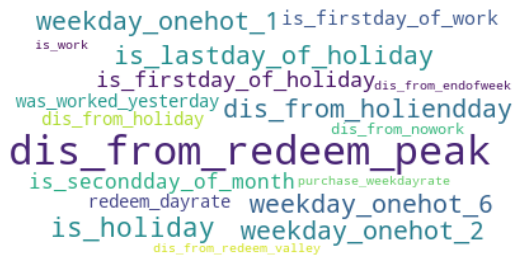

In [90]:
draw_cloud(winer_features_purchase)

In [91]:
winer_features_purchase

['is_holiday',
 'dis_from_redeem_peak',
 'is_lastday_of_holiday',
 'dis_from_holiendday',
 'weekday_onehot_6',
 'weekday_onehot_2',
 'weekday_onehot_1',
 'is_firstday_of_holiday',
 'is_secondday_of_month',
 'is_firstday_of_work',
 'was_worked_yesterday',
 'redeem_dayrate',
 'dis_from_holiday',
 'dis_from_nowork',
 'dis_from_redeem_peak%%%%dis_from_redeem_valley',
 'purchase_weekdayrate',
 'is_work',
 'dis_from_redeem_peak%%%%dis_from_endofweek']

In [92]:
final_dataset = feature[['is_holiday',
 'dis_from_redeem_peak',
 'is_lastday_of_holiday',
 'dis_from_holiendday',
 'weekday_onehot_6',
 'weekday_onehot_2',
 'weekday_onehot_1',
 'is_firstday_of_holiday',
 'is_secondday_of_month',
 'is_firstday_of_work',
 'was_worked_yesterday',
 'redeem_dayrate',
 'dis_from_holiday',
 'dis_from_nowork',
 'dis_from_redeem_peak%%%%dis_from_redeem_valley',
 'purchase_weekdayrate',
 'is_work',
 'dis_from_redeem_peak%%%%dis_from_endofweek']+ labels + ['report_date']]

In [95]:
final_dataset.to_csv('Feature/redeem_best_feature_0122.csv', index=False)